In [489]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from lazypredict.Supervised import LazyRegressor
from scipy import stats

In [490]:
path = "../data/preprocessed.feather"

df = pd.read_feather(path)

In [491]:
text = df[['sen1', 'sen2', 'info1', 'info2']].values
# text = df[['sen1', 'sen2']].values
flattened_list = text.flatten()

vectorizer = TfidfVectorizer()

vocabulary = vectorizer.fit_transform(flattened_list)
vocabulary = vocabulary.toarray()

print(vocabulary.shape)

(15256, 9920)


In [492]:
# centered_vocabulary = vocabulary - np.mean(vocabulary, axis=0)
# pca = PCA(n_components=1000)
# components = pca.fit_transform(centered_vocabulary)

Tsvd = TruncatedSVD(n_components=1100)
truncated = Tsvd.fit_transform(vocabulary)
print(truncated.shape)

(15256, 1100)


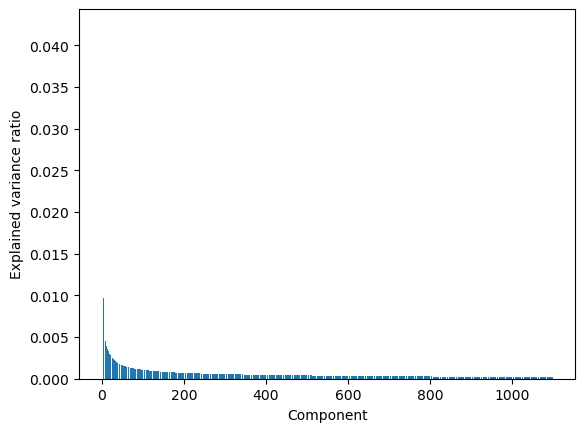

In [493]:
plt.bar(range(len(Tsvd.explained_variance_ratio_)), Tsvd.explained_variance_ratio_)
# plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')
plt.show()

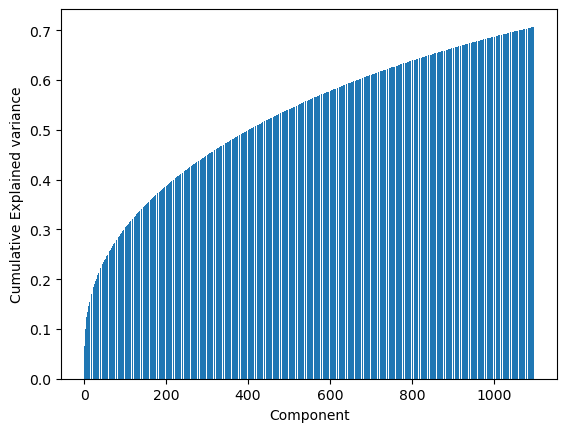

In [494]:
plt.bar(range(len(Tsvd.explained_variance_ratio_)), np.cumsum(Tsvd.explained_variance_ratio_))
plt.xlabel('Component')
plt.ylabel('Cumulative Explained variance')
plt.show()

In [495]:
# cov = np.corrcoef(vocabulary)

# eigenval, eigenvec = np.linalg.eig(cov)

# order = np.argsort(eigenval)[::-1]
# eigenval, eigenvec = eigenval[order], eigenvec[order]
# plt.scatter(range(len(eigenval)), eigenval)
# plt.show()

# var_exp = [val*100/sum(eigenval) for val in eigenval]
# cum_sum = np.cumsum(var_exp)

# plt.bar(range(len(eigenval)), var_exp, label='Explained Variance')
# plt.step(range(len(eigenval)), cum_sum, 'r:',
#          where='mid', label='Cumulative Sum')
# plt.ylabel('Explained Variance (%)')
# plt.xlabel('Principal Components')
# plt.legend(loc='center right')

In [496]:
# plt.scatter(components[:,0], components[:,1])
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.show()

In [497]:
#data = df[['score','sen1','sen2']]

y = df['score'].values

X_set = truncated

# X = [np.concatenate([X_set[i], X_set[i+1]]) for i in range(0,len(X_set),4)]
X = [np.concatenate([X_set[i], X_set[i+1], X_set[i+2], X_set[i+3]]) for i in range(0,len(X_set),4)]
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [498]:
X.shape

(3814, 4400)

In [499]:
# exclude = ['QuantileRegressor']

# metric = stats.pearsonr

# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=metric)
# models,predictions = reg.fit(X_train, X_test, y_train, y_test)
# models

In [500]:
n_trees = 250

extra_trees = ExtraTreesRegressor(n_estimators=n_trees, random_state=0)
lightGBM = LGBMRegressor(n_estimators=n_trees, random_state=0)

In [501]:
# extra_trees.fit(X_train, y_train)
lightGBM.fit(X_train, y_train)

LGBMRegressor(n_estimators=250, random_state=0)

In [511]:
# et_predictions = extra_trees.predict(X_test)
lgbm_predictions = lightGBM.predict(X)

# print("Extra Trees Regressor Pearson score:", stats.pearsonr(y_test, et_predictions))
print("Light-GMB Pearson score:", stats.pearsonr(y, lgbm_predictions))

(3814,)
Light-GMB Pearson score: (0.971680250907356, 0.0)


In [513]:
results = pd.DataFrame(data={
    "sen1": [s[0] for s in text],
    "sen2": [s[1] for s in text],
    "scores": y,
    "preds": lgbm_predictions,
    "mae": np.abs(lgbm_predictions-y)
})

results = results.sort_values(by="mae", ascending=False)
results.head(10)

,sen1,sen2,scores,preds,mae
2048,bring to a certain pressure,bring to a certain spiritual state.,0.00,3.70,3.70
2215,(Cause to) become widely distributed.,become or cause to become obstructed.,0.00,3.40,3.40
347,act of constructing,the act of constructing something.,4.75,1.38,3.37
3451,"If a term exists in a document, its value in t...",If a term appears in the document then its val...,5.00,1.65,3.35
1548,the state of being employed,the state of being employed or having a job.,5.00,1.83,3.17
1756,the act or capability of seeing,the act of looking or seeing or observing.,4.20,1.03,3.17
3423,The key to Dynamic Programming is to find the ...,"In general, dynamic programming is used on opt...",4.00,0.90,3.10
1887,location sheltered from the wind,a portion removed from the whole.,0.00,3.05,3.05
965,giving a reference or citation of something,"change the nature, purpose, or function of som...",0.00,2.95,2.95
1715,interfere with someone else's activity,destroy the peace or tranquility of.,0.40,3.24,2.84


In [514]:
def to_latex(df: pd.DataFrame):
    inner = ""
    for idx, row in df.iterrows():
        inner += "\t" + row.sen1.replace('&', '\&') + " & " + row.sen2.replace('&', '\&') + f" & {row.scores: .2f} & {row.preds: .2f}\\\\\n\t\hline\n"
    outer = ("\\begin{tabular}{|m{5cm}|m{5cm}|m{1.45cm}|m{1.45cm}|}\n"
             "    \hline\n"
             "    Sentence1 & Sentence2 & Score & Prediction \\\\\n"
             "    \hline\hline\n"
             f"{inner}"
             "\end{tabular}\n")
    print(outer)

to_latex(results.head(10))

\begin{tabular}{|m{5cm}|m{5cm}|m{1.45cm}|m{1.45cm}|}
    \hline
    Sentence1 & Sentence2 & Score & Prediction \\
    \hline\hline
	bring to a certain pressure & bring to a certain spiritual state. &  0.00 &  3.70\\
	\hline
	(Cause to) become widely distributed. & become or cause to become obstructed. &  0.00 &  3.40\\
	\hline
	act of constructing & the act of constructing something. &  4.75 &  1.38\\
	\hline
	If a term exists in a document, its value in the vector is not equal to zero. & If a term appears in the document then its value in the vector is non-zero. &  5.00 &  1.65\\
	\hline
	the state of being employed & the state of being employed or having a job. &  5.00 &  1.83\\
	\hline
	the act or capability of seeing & the act of looking or seeing or observing. &  4.20 &  1.03\\
	\hline
	The key to Dynamic Programming is to find the structure of optimal solutions. & In general, dynamic programming is used on optimisation problems, where the most efficient solution is needed. &  4.0